## XLM-R + Adversarial Training & Sentiment Analysis
### Hindi-English

---

## **Installations and Preparation**
Code blocks below for downloading files, installing dependencies and setting up notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Installations:
!pip install wget
!pip install torch==1.4.0
!pip install sentencepiece

!pip3 install transformers==3.5.1

     |████████████████████████████████| 753.4 MB 6.5 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.


In [3]:

# These lines for Google Collab
%cd drive/MyDrive/NLP_finalproj
!ls

/content/drive/.shortcut-targets-by-id/1kYsHJjezUtbe2kNCxBpGemHpq_sJGBY6/NLP_finalproj
data		    preprocessing		   XLM-R_train_hindi.ipynb
main.zip	    README.md
NLP_finalproj-main  XLM-R_hindi_adversarial.ipynb


In [4]:
# These lines for downloading the repo+datasets from github if not already
import os
import wget

# print('Downloading dataset...')
#
# # The URL for the dataset zip file.
# url = 'https://github.com/rsgoss/NLP_finalproj/archive/main.zip'
#
# # Download the file (if we haven't already)
# if not os.path.exists('./main.zip'):
#     wget.download(url, './main.zip')
#
# # Unzip the dataset (if we haven't already)
# if not os.path.exists('./main/'):
#     !unzip main.zip

In [5]:
# import our packages...
import tensorflow as tf
import torch

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Parsing Data

In [6]:
import pandas as pd

# Load the datasets into a pandas dataframe.
df_train = pd.read_csv("data/hindi-english/train_14k_split.csv" )
df_val = pd.read_csv("data/hindi-english/val_3k_split.csv" )

# Report the number of sentences.
print('Number of training sentences in training set: {:,}\n'.format(df_train.shape[0]))
print('Number of training sentences in val set: {:,}\n'.format(df_val.shape[0]))

# Get the lists of sentences and their labels for train and val datasets
sentences_train = df_train.sentence.values
labels_train = df_train.label.values
sentences_val = df_val.sentence.values
labels_val = df_val.label.values

print('Train dataset: \n', df_train.head())
print('Val dataset: \n',df_val.head())

Number of training sentences in training set: 13,967

Number of training sentences in val set: 2,997

Train dataset: 
       id                                           sentence  label sentiment
0   4330  nen á vist bolest vztek smutek zmatek osam ě l...      1   neutral
1  41616  Haan yaar neha pensive pensive kab karega woh ...      1   neutral
2   6648  television media congress ke liye nhi h Ye toh...      0  negative
3   2512  All India me nrc lagu kare w Kashmir se dhara ...      2  positive
4    610  who Pagal hai kya They aren t real issues Mand...      1   neutral
Val dataset: 
       id                                           sentence  label sentiment
0  30258  modi mantrimandal may samil honay par badhai n...      2  positive
1  16648                Rashid Tu toh naamakool hai Mare h       0  negative
2  28511  U saw caste and religion in them nation saw ta...      0  negative
3  10466  sir local police station pe complaint krne par...      1   neutral
4  19266  Ve Maahi 

## Tokenizing Data
1. Tokenize the sentence.
2. Prepend the `[CLS]` token to the start.
3. Append the `[SEP]` token to the end.
4. Map tokens to their IDs.
5. Pad or truncate the sentence to `max_length`
6. Create attention masks for [PAD] tokens.

In [7]:
from transformers import XLMRobertaTokenizer
# Load the BERT tokenizer.
print('Loading XLMRobertaTokenizer ...')
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base', do_lower_case=True)
tokenized_train = tokenizer.tokenize(sentences_train[0])
tokenized_ids_train = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_train[0]))
tokenized_val = tokenizer.tokenize(sentences_val[0])
tokenized_ids_val = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_val[0]))

# Print the original train sentence; tokenized and IDs mapped.
print('Original Train Sentence: ', sentences_train[0])
print('Tokenized Train Sentence: ', tokenized_train)
print('Token Train IDs: ', tokenized_ids_train)

# Print the original val sentence; tokenized and IDs mapped.
print('Original Val Sentence: ', sentences_val[0])
print('Tokenized Train Sentence: ', tokenized_val)
print('Token Train IDs: ', tokenized_ids_val)

Loading XLMRobertaTokenizer ...


Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Original Train Sentence:  nen á vist bolest vztek smutek zmatek osam ě lost beznad ě j a nakonec jen klid Asi takhle vypad á m ů j life
Tokenized Train Sentence:  ['▁nen', '▁á', '▁vist', '▁bolest', '▁vz', 'tek', '▁smut', 'ek', '▁z', 'ma', 'tek', '▁osam', '▁', 'ě', '▁lost', '▁bez', 'nad', '▁', 'ě', '▁j', '▁a', '▁nakonec', '▁jen', '▁klid', '▁Asi', '▁takhle', '▁vy', 'pad', '▁á', '▁m', '▁', 'ů', '▁j', '▁life']
Token Train IDs:  [73351, 392, 18591, 112616, 10682, 2142, 67456, 343, 97, 192, 2142, 99892, 6, 2353, 72856, 1209, 9169, 6, 2353, 1647, 10, 95002, 7349, 122166, 37933, 167809, 1154, 4299, 392, 347, 6, 1170, 1647, 6897]
Original Val Sentence:  modi mantrimandal may samil honay par badhai narmaday har
Tokenized Train Sentence:  ['▁modi', '▁man', 'tri', 'man', 'dal', '▁may', '▁sam', 'il', '▁ho', 'nay', '▁par', '▁bad', 'hai', '▁na', 'rma', 'day', '▁har']
Token Train IDs:  [43381, 332, 3996, 669, 2465, 1543, 1289, 379, 739, 13650, 366, 6494, 15251, 24, 17668, 5636, 182]


In [8]:
import numpy as np

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_train = []
attention_masks_train = []
input_ids_val = []
attention_masks_val = []

# Loop through sentences for Train dataset
for sent in sentences_train:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 160,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    # Add the encoded sentence to the list.
    input_ids_train.append(encoded_dict['input_ids'])

    # Add its attention mask (simply differentiates padding from non-padding).
    attention_masks_train.append(encoded_dict['attention_mask'])

# Loop through sentences for Val dataset
for sent in sentences_val:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 160,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids_val.append(encoded_dict['input_ids'])
    attention_masks_val.append(encoded_dict['attention_mask'])
    
# Convert the lists into tensors.
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
labels_train = torch.tensor(labels_train)

input_ids_val = torch.cat(input_ids_val, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)
labels_val = torch.tensor(labels_val)

print('Original train sentence \n: ', sentences_train[0])
print('Train Token IDs \n:', input_ids_train)
print('Train labels: \n', labels_train)
print('Train sentence shape:', np.shape(sentences_train))
print('Train token shape:', np.shape(input_ids_train))
print('Train token mask shape:', np.shape(attention_masks_train))
print('Train label shape:', np.shape(labels_train))
print('\n')
print('Original val sentence \n: ', sentences_val[0])
print('Val Token IDs \n:', input_ids_val[0])
print('Val labels: \n', labels_val)
print('Train sentence shape:', np.shape(sentences_val))
print('Train token shape:', np.shape(input_ids_val))
print('Train token mask shape:', np.shape(attention_masks_val))
print('Train label shape:', np.shape(labels_val))


Original train sentence 
:  nen á vist bolest vztek smutek zmatek osam ě lost beznad ě j a nakonec jen klid Asi takhle vypad á m ů j life
Train Token IDs 
: tensor([[     0,  73351,    392,  ...,      1,      1,      1],
        [     0,   1391,     66,  ...,      1,      1,      1],
        [     0, 113976,   2450,  ...,      1,      1,      1],
        ...,
        [     0,  92010,   7643,  ...,      1,      1,      1],
        [     0,  49191,  49191,  ...,      1,      1,      1],
        [     0, 114775,     13,  ...,      1,      1,      1]])
Train labels: 
 tensor([1, 1, 0,  ..., 2, 2, 1])
Train sentence shape: (13967,)
Train token shape: torch.Size([13967, 160])
Train token mask shape: torch.Size([13967, 160])
Train label shape: torch.Size([13967])


Original val sentence 
:  modi mantrimandal may samil honay par badhai narmaday har
Val Token IDs 
: tensor([    0, 43381,   332,  3996,   669,  2465,  1543,  1289,   379,   739,
        13650,   366,  6494, 15251,    24, 17668,  5

## Prepare the Training and Validation Sets
Create model to be fine-tuned. Edit settings for training and validation.

In [9]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [10]:
from transformers import XLMRobertaForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [11]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The XLMRoberta model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The XLMRoberta model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (250002, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias     

## Optimizer & Learning Rate Scheduler
Now that we have our model loaded we need to grab the training hyperparameters from within the stored model. For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper):
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We chose:
- Batch size: 32 (set when creating our DataLoaders)
- Learning rate: 3e-5
- Epochs: 4 (we'll see that this is probably too many...)
- The epsilon parameter eps = 1e-8 is "a very small number to prevent any division by zero in the implementation".

In [12]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 3e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [13]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## **Train Model**
Training should be done on a GPU

In [14]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [15]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        (loss, logits) = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    437.    Elapsed: 0:00:33.
  Batch    80  of    437.    Elapsed: 0:01:07.
  Batch   120  of    437.    Elapsed: 0:01:42.
  Batch   160  of    437.    Elapsed: 0:02:17.
  Batch   200  of    437.    Elapsed: 0:02:53.
  Batch   240  of    437.    Elapsed: 0:03:29.
  Batch   280  of    437.    Elapsed: 0:04:06.
  Batch   320  of    437.    Elapsed: 0:04:42.
  Batch   360  of    437.    Elapsed: 0:05:20.
  Batch   400  of    437.    Elapsed: 0:05:57.

  Average training loss: 0.94
  Training epcoh took: 0:06:31

Running Validation...
  Accuracy: 0.58
  Validation Loss: 0.88
  Validation took: 0:00:26

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    437.    Elapsed: 0:00:37.
  Batch    80  of    437.    Elapsed: 0:01:14.
  Batch   120  of    437.    Elapsed: 0:01:51.
  Batch   160  of    437.    Elapsed: 0:02:28.
  Batch   200  of    437.    Elapsed: 0:03:05.
  Batch   240  of    437.    Elapsed: 0:03:42.
  Batch  

In [17]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.94,0.88,0.58,0:06:31,0:00:26
2,0.83,0.84,0.62,0:06:44,0:00:26
3,0.74,0.87,0.61,0:06:44,0:00:26
4,0.66,0.90,0.61,0:06:44,0:00:26
5,0.59,0.96,0.61,0:06:44,0:00:26


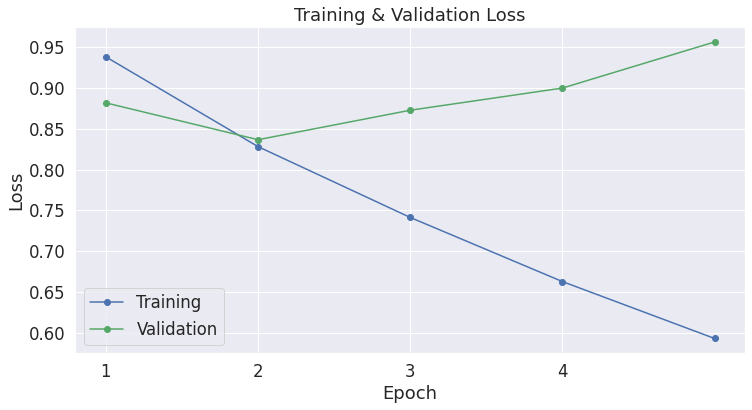

In [18]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()